# CIFAR Conv Net

И так, в этом ноутбуке Вы сделаете превую в своей жизни сверточную сеть! На сложном датасете. Cкачайте его кстати, 

In [1]:
#!mkdir cifar10
#!curl -o cifar-10-python.tar.gz https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
#!tar -xvzf cifar-10-python.tar.gz -C cifar10

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from cifar import load_CIFAR10
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

cifar10_dir = './cifar10/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

In [3]:
print X_train.shape, y_train.shape, X_test.shape, y_test.shape

(50000, 3, 32, 32) (50000,) (10000, 3, 32, 32) (10000,)


In [4]:
y_train = y_train.astype(np.int32)
X_train = X_train.astype(np.float32)
y_test = y_test.astype(np.int32)
X_test = X_test.astype(np.float32)

### Preprocessing

In [5]:
X_train -= np.mean(X_train)
X_test -= np.mean(X_test)

In [6]:
from sklearn import cross_validation

/home/ec2-user/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [7]:
X_train, X_val, y_train, y_val = cross_validation.train_test_split(X_train, y_train, test_size = 0.1)

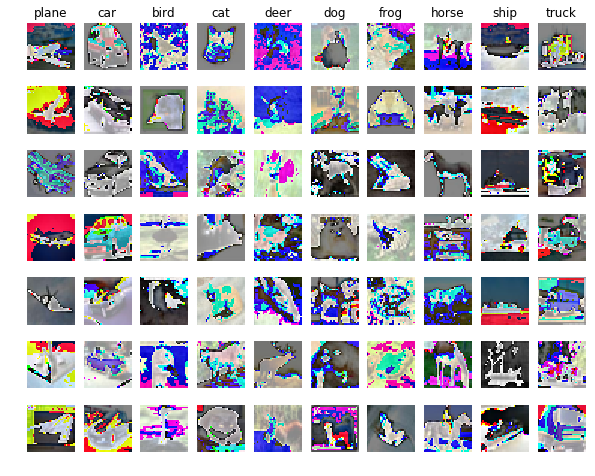

In [8]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8').transpose(1, 2, 0))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

<h1 align="center">First of all -- Checking Questions</h1> 

**Вопрос 1**: Чем отличаются современные сверточные сети от сетей 5 летней давности?

Раньше сети были неглубокие(порядка 11 слоёв), сейчас сети порядка 150 слоёв, придуманы разные архитектуры сетей:
Если сеть глубокая, то с одним loss слоем происходит затухание градиентов, и слои, которые глубже, не обучаются.
В GoogleNet эта проблема решена с помощью использования большого числа слоёв с softmax. Из-за этого она по сути является сетью, состоящей из нескольких менее глубоких сетей. Также в GoogleNet используются всевозможные свертки

ResNet - к VGG добавляются дополнительные слои, shortcuts + batch normalization, получаем несколько сетей разной глубины, которые тренируются одновременно(у этих сетей общие слои и параметры)(важно - одинаковые размерности)
AlexNet, VGG, GoogleNet, ResNet

**Вопрос 2**: Какие неприятности могут возникнуть во время обучения современных нейросетей?

Затухание градиентов - из-за того, что сеть глубокая, градиенты затухают и не проходят до конца, слои, которые глубже, перестают обучаться.

Затухание активаций (все нули на каком-то слое)

Долгое время работы сети (ждать результата на уже обученной сети)

Необходимо адаптировать для реальных задач (может быть нетривиальной задачей, если нужно обучаться на каких-то особенных данных)

**Вопрос 3**: У вас есть очень маленький датасет из 100 картинок, классификация, но вы очень хотите использовать нейросеть, какие неприятности вас ждут и как их решить? что делать если первый вариант  решения не заработает?

На маленьком датасете сеть может переобучиться (просто запомнит эти картинки). Для того чтобы увеличить датасет, можно искусственно сгенерировать данные: изменить яркость, цвет картинки, фокус, добавить блики, шумы, размытие, изменить фон(в зависимости от задачи), повернуть картинку, сжать, растянуть вдоль осей.

**Вопрос 4**: Как сделать стайл трансфер для музыки? oO

С помощью преобразования Фурье строим спектрограмму по аудиозаписи, спектрограмму рассматриваем как картинку размером 1*T с f числом каналов(T - временной промежуток, f - частота). Далее обучаем на спектрограммах сверточную нейросеть, которая на каждом слое должна минимизировать разность активаций для спектрограммы, которую нужно преобразовать(подается на вход сети) и для спектрограммы, которая отвечает за аудиозапись определенного стиля. 
Полученную на выходе нейросети спектрограмму нужно перевести обратно в аудио (для этого существуют специальные алгоритмы, например, алгоритм Гриффина-Лима).

In [9]:
import lasagne
from theano import tensor as T
from lasagne.nonlinearities import *

input_X = T.tensor4("X")
target_y = T.vector("target Y integer",dtype='int32')

Using cuDNN version 5110 on context None
Mapped name None to device cuda0: GRID K520 (0000:00:03.0)


### Соберите нейронку: 
- Many times x (Conv+Pool)
- Many small convolutions like 3x3
- Batch Norm 
- Residual Connection
- Data Augmentation 
- Learning rate Schedule 
- ...

### Для вдохновения 
- http://torch.ch/blog/2015/07/30/cifar.html
- https://github.com/szagoruyko/wide-residual-networks 

### Самое интересное
- Для сдачи задания нужно набрать на точность тесте > **92.5**% (это займет много времени, торопитесь :) )
- Для получения бонусных баллов > **95.0**%
- Будет очень хорошо если вы придумаете свою архитектуру или сможете обучить что-то из вышеперечисленного :)
- А для обучения всего этого добра вам будет куда удобнее использовать GPU на Amazon 
    - Инструкция https://github.com/persiyanov/ml-mipt/tree/master/amazon-howto 
    - Вам помогут tmux, CuDNN, ssh tunnel, nvidia-smi, ... 
    - Have fun :)

In [10]:
from lasagne.nonlinearities import softmax, rectify

In [11]:
from lasagne import init
from lasagne import layers as ll

In [19]:
net = ll.InputLayer(shape=(None, 3, 32, 32), input_var=input_X)
net = ll.GaussianNoiseLayer(net)


def block(net, num_filters=192, filter_size=(3, 3), pad=1):
    net = ll.Conv2DLayer(net, num_filters=num_filters, filter_size=filter_size, pad=pad, W=init.Normal()) # сверточный слой
    net = ll.BatchNormLayer(net, epsilon=1e-3)
    net = ll.NonlinearityLayer(net)
    return net

net = block(net, 64)
net = ll.DropoutLayer(net, 0.3)

net = block(net, 64)
net = ll.MaxPool2DLayer(net, 2, 2)

net = block(net, 128)
net = ll.DropoutLayer(net, 0.4)

net = block(net, 128)
net = ll.MaxPool2DLayer(net, 2, 2)

net = block(net, 256)
net = ll.DropoutLayer(net, 0.4)

net = block(net, 256)
net = ll.DropoutLayer(net, 0.4)

net = block(net, 256)
net = ll.MaxPool2DLayer(net, 2, 2)

net = block(net, 512)
net = ll.DropoutLayer(net, 0.4)

net = block(net, 512)
net = ll.DropoutLayer(net, 0.4)

net = block(net, 512)
net = ll.MaxPool2DLayer(net, 2, 2)

net = block(net, 512)
net = ll.DropoutLayer(net, 0.4)

net = block(net, 512)
net = ll.DropoutLayer(net, 0.4)

net = block(net, 512)
net = ll.MaxPool2DLayer(net, 2, 2)

net = ll.DenseLayer(net, int(512), W=init.Normal(), nonlinearity=rectify)
net = ll.BatchNormLayer(net, epsilon=1e-3)
net = ll.NonlinearityLayer(net)
net = ll.DropoutLayer(net, 0.5)
net = ll.DenseLayer(net, num_units=10, W=init.Normal(), nonlinearity=softmax)

In [20]:
y_predicted = lasagne.layers.get_output(net)
all_weights = lasagne.layers.get_all_params(net, regularizable=True)
print all_weights

[W, gamma, W, gamma, W, gamma, W, gamma, W, gamma, W, gamma, W, gamma, W, gamma, W, gamma, W, gamma, W, gamma, W, gamma, W, gamma, W, gamma, W]


In [21]:
#reg = lasagne.regularization.l2(y_predicted)
weight_decay = 0.0005

loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean() # + reg * 0.0005
accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()
weightsl2 = lasagne.regularization.regularize_network_params(net, lasagne.regularization.l2)
loss += weight_decay * weightsl2

In [22]:
learning_rate = T.scalar(name='learning_rate')
updates = lasagne.updates.nesterov_momentum(loss, all_weights, learning_rate=learning_rate, momentum=0.9)

In [23]:
train_fun = theano.function([input_X,target_y, learning_rate],[loss, accuracy], updates=updates)
accuracy_fun = theano.function([input_X,target_y],accuracy)

### Вот и всё, пошли её учить

In [24]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

# Процесс обучения

In [91]:
import time

num_epochs = 200 #количество проходов по данным

batch_size = 128 #размер мини-батча

base_lr = 0.01
lr_decay = 1e-5
num_epochs_decay = 25

lr = base_lr

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    if epoch % num_epochs_decay == 0:
        lr = lr - lr_decay
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train,batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets, lr)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))

Epoch 1 of 200 took 333.140s
  training loss (in-iteration):		5.210953
  train accuracy:		20.46 %
  validation accuracy:		27.14 %
Epoch 2 of 200 took 333.129s
  training loss (in-iteration):		4.742054
  train accuracy:		32.33 %
  validation accuracy:		36.56 %
Epoch 3 of 200 took 333.260s
  training loss (in-iteration):		4.390575
  train accuracy:		40.16 %
  validation accuracy:		43.89 %
Epoch 4 of 200 took 333.419s
  training loss (in-iteration):		4.061358
  train accuracy:		47.57 %
  validation accuracy:		49.62 %
Epoch 5 of 200 took 333.448s
  training loss (in-iteration):		3.757430
  train accuracy:		53.69 %
  validation accuracy:		53.87 %
Epoch 6 of 200 took 333.442s
  training loss (in-iteration):		3.486942
  train accuracy:		59.07 %
  validation accuracy:		59.50 %
Epoch 7 of 200 took 333.514s
  training loss (in-iteration):		3.242952
  train accuracy:		63.71 %
  validation accuracy:		62.78 %
Epoch 8 of 200 took 333.531s
  training loss (in-iteration):		3.029386
  train accuracy:		

KeyboardInterrupt: 

In [92]:
import time

num_epochs = 100 #количество проходов по данным

batch_size = 128 #размер мини-батча

base_lr = 0.001
lr_decay = 1e-5
num_epochs_decay = 25

lr = base_lr

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    if epoch % num_epochs_decay == 0:
        lr = lr - lr_decay
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train,batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets, lr)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))

Epoch 1 of 100 took 333.544s
  training loss (in-iteration):		0.809843
  train accuracy:		95.32 %
  validation accuracy:		84.07 %
Epoch 2 of 100 took 333.616s
  training loss (in-iteration):		0.760861
  train accuracy:		96.78 %
  validation accuracy:		84.46 %
Epoch 3 of 100 took 333.569s
  training loss (in-iteration):		0.739732
  train accuracy:		97.40 %
  validation accuracy:		85.20 %
Epoch 4 of 100 took 333.559s
  training loss (in-iteration):		0.728098
  train accuracy:		97.64 %
  validation accuracy:		85.00 %
Epoch 5 of 100 took 333.551s
  training loss (in-iteration):		0.716467
  train accuracy:		97.87 %
  validation accuracy:		85.24 %
Epoch 6 of 100 took 333.463s
  training loss (in-iteration):		0.707429
  train accuracy:		98.03 %
  validation accuracy:		85.42 %
Epoch 7 of 100 took 333.555s
  training loss (in-iteration):		0.699300
  train accuracy:		98.14 %
  validation accuracy:		84.60 %
Epoch 8 of 100 took 333.424s
  training loss (in-iteration):		0.691243
  train accuracy:		

KeyboardInterrupt: 

In [93]:
import time

num_epochs = 100 #количество проходов по данным

batch_size = 128 #размер мини-батча

base_lr = 0.0005
lr_decay = 1e-5
num_epochs_decay = 25

lr = base_lr

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    if epoch % num_epochs_decay == 0:
        lr = lr - lr_decay
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train,batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets, lr)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))

Epoch 1 of 100 took 333.225s
  training loss (in-iteration):		0.639126
  train accuracy:		98.91 %
  validation accuracy:		85.92 %
Epoch 2 of 100 took 333.147s
  training loss (in-iteration):		0.635564
  train accuracy:		98.95 %
  validation accuracy:		86.04 %
Epoch 3 of 100 took 333.187s
  training loss (in-iteration):		0.631421
  train accuracy:		99.08 %
  validation accuracy:		85.72 %
Epoch 4 of 100 took 333.045s
  training loss (in-iteration):		0.632716
  train accuracy:		99.00 %
  validation accuracy:		85.60 %


KeyboardInterrupt: 

Первая сетка 128 batch, momentum

In [94]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 92.5:
    print "Achievement unlocked: колдун 80 уровня"
else:
    print "Нужно больше магии!"

Final results:
  test accuracy:		86.92 %
Нужно больше магии!


Что было ещё

In [25]:
import time

num_epochs = 200 #количество проходов по данным

batch_size = 128 #размер мини-батча

base_lr = 0.01
lr_decay = 1e-7
num_epochs_decay = 25

lr = base_lr

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    if epoch % num_epochs_decay == 0:
        lr = lr / 2
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train,batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets, lr)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))

Epoch 1 of 200 took 333.078s
  training loss (in-iteration):		5.248242
  train accuracy:		18.66 %
  validation accuracy:		25.38 %
Epoch 2 of 200 took 332.899s
  training loss (in-iteration):		4.826395
  train accuracy:		32.06 %
  validation accuracy:		36.20 %
Epoch 3 of 200 took 332.954s
  training loss (in-iteration):		4.517028
  train accuracy:		41.35 %
  validation accuracy:		44.55 %
Epoch 4 of 200 took 332.955s
  training loss (in-iteration):		4.253051
  train accuracy:		48.89 %
  validation accuracy:		51.34 %
Epoch 5 of 200 took 332.939s
  training loss (in-iteration):		4.030434
  train accuracy:		54.31 %
  validation accuracy:		55.87 %
Epoch 6 of 200 took 333.367s
  training loss (in-iteration):		3.825982
  train accuracy:		59.52 %
  validation accuracy:		60.30 %
Epoch 7 of 200 took 333.592s
  training loss (in-iteration):		3.660221
  train accuracy:		62.92 %
  validation accuracy:		62.66 %
Epoch 8 of 200 took 333.011s
  training loss (in-iteration):		3.490254
  train accuracy:		

KeyboardInterrupt: 

In [42]:
import time

num_epochs = 200 #количество проходов по данным

batch_size = 100 #размер мини-батча

base_lr = 1
lr_decay = 0.005
num_epochs_decay = 25

lr = base_lr

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    if epoch % num_epochs_decay == 0:
        lr = lr - lr_decay
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train,batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets, lr)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))

Epoch 1 of 200 took 321.903s
  training loss (in-iteration):		2.415999
  train accuracy:		12.45 %
  validation accuracy:		13.22 %
Epoch 2 of 200 took 321.830s
  training loss (in-iteration):		2.229364
  train accuracy:		15.46 %
  validation accuracy:		16.92 %
Epoch 3 of 200 took 321.758s
  training loss (in-iteration):		2.166116
  train accuracy:		17.90 %
  validation accuracy:		20.80 %
Epoch 4 of 200 took 321.744s
  training loss (in-iteration):		1.997520
  train accuracy:		24.42 %
  validation accuracy:		25.96 %
Epoch 5 of 200 took 321.956s
  training loss (in-iteration):		1.922267
  train accuracy:		26.78 %
  validation accuracy:		28.80 %
Epoch 6 of 200 took 321.793s
  training loss (in-iteration):		1.800880
  train accuracy:		31.94 %
  validation accuracy:		32.94 %
Epoch 7 of 200 took 321.973s
  training loss (in-iteration):		1.716821
  train accuracy:		35.61 %
  validation accuracy:		36.44 %
Epoch 8 of 200 took 321.485s
  training loss (in-iteration):		1.627895
  train accuracy:		

KeyboardInterrupt: 

## Заполните форму

https://goo.gl/forms/EeadABISlVmdJqgr2 